In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time

C:\Users\Michal\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Parsing provided by AlQuraishi

In [12]:
NUM_AAS = 20
NUM_DIMENSIONS = 3

def masking_matrix(mask, name=None):
    """ Constructs a masking matrix to zero out pairwise distances due to missing residues or padding. 

    Args:
        mask: 0/1 vector indicating whether a position should be masked (0) or not (1)

    Returns:
        A square matrix with all 1s except for rows and cols whose corresponding indices in mask are set to 0.
        [MAX_SEQ_LENGTH, MAX_SEQ_LENGTH]
    """

    with tf.name_scope(name, 'masking_matrix', [mask]) as scope:
        mask = tf.convert_to_tensor(mask, name='mask')

        mask = tf.expand_dims(mask, 0)
        base = tf.ones([tf.size(mask), tf.size(mask)])
        matrix_mask = base * mask * tf.transpose(mask)

        return matrix_mask
        
def read_protein(filename_queue, max_length, num_evo_entries=21, name=None):
    """ Reads and parses a ProteinNet TF Record. 

        Primary sequences are mapped onto 20-dimensional one-hot vectors.
        Evolutionary sequences are mapped onto num_evo_entries-dimensional real-valued vectors.
        Secondary structures are mapped onto ints indicating one of 8 class labels.
        Tertiary coordinates are flattened so that there are 3 times as many coordinates as 
        residues.

        Evolutionary, secondary, and tertiary entries are optional.

    Args:
        filename_queue: TF queue for reading files
        max_length:     Maximum length of sequence (number of residues) [MAX_LENGTH]. Not a 
                        TF tensor and is thus a fixed value.

    Returns:
        id: string identifier of record
        one_hot_primary: AA sequence as one-hot vectors
        evolutionary: PSSM sequence as vectors
        secondary: DSSP sequence as int class labels
        tertiary: 3D coordinates of structure
        matrix_mask: Masking matrix to zero out pairwise distances in the masked regions
        pri_length: Length of amino acid sequence
        keep: True if primary length is less than or equal to max_length
    """

    with tf.name_scope(name, 'read_protein', []) as scope:
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        context, features = tf.parse_single_sequence_example(serialized_example,
                                context_features={'id': tf.FixedLenFeature((1,), tf.string)},
                                sequence_features={
                                    'primary':      tf.FixedLenSequenceFeature((1,),               tf.int64),
                                    'evolutionary': tf.FixedLenSequenceFeature((num_evo_entries,), tf.float32, allow_missing=True),
                                    'secondary':    tf.FixedLenSequenceFeature((1,),               tf.int64,   allow_missing=True),
                                    'tertiary':     tf.FixedLenSequenceFeature((NUM_DIMENSIONS,),  tf.float32, allow_missing=True),
                                    'mask':         tf.FixedLenSequenceFeature((1,),               tf.float32, allow_missing=True)})
        id_ = context['id'][0]
        primary =   tf.to_int32(features['primary'][:, 0])
        evolutionary =          features['evolutionary']
        secondary = tf.to_int32(features['secondary'][:, 0])
        tertiary =              features['tertiary']
        mask =                  features['mask'][:, 0]

        pri_length = tf.size(primary)
        keep = pri_length <= max_length

        one_hot_primary = tf.one_hot(primary, NUM_AAS)

        # Generate tertiary masking matrix--if mask is missing then assume all residues are present
        mask = tf.cond(tf.not_equal(tf.size(mask), 0), lambda: mask, lambda: tf.ones([pri_length]))
        ter_mask = masking_matrix(mask, name='ter_mask')        

        return id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep

Definitions of how to calculate dihedral angles and set up a bidirecitonal lstm

In [22]:
def tf_rad2deg(rad):
    pi_on_180 = 0.017453292519943295
    return rad / pi_on_180

# takes a 4-dimensional tensor (N, K, 4, 3) and outputs (N, K, 3) angles
def dihedral_tf3(p):
    p0 = tf.gather(p, 0, axis=2)
    p1 = tf.gather(p, 1, axis=2)
    p2 = tf.gather(p, 2, axis=2)
    p3 = tf.gather(p, 3, axis=2)
    
    b0 = -1.0 * (tf.subtract(p1, p0))
    b1 = tf.subtract(p2, p1)
    b2 = tf.subtract(p3, p2)
    
    b1 = tf.divide(b1, tf.norm(b1, axis=2, keepdims=True))
    b1 = tf.where(tf.is_nan(b1), tf.ones_like(b1), b1) # what to do when norm is 0?
    
    v = tf.subtract(b0, tf.einsum('bi,bij->bij', tf.einsum('bij,bij->bi', b0, b1), b1))
    w = tf.subtract(b2, tf.einsum('bi,bij->bij', tf.einsum('bij,bij->bi', b2, b1), b1))
    
    x = tf.reduce_sum( tf.multiply( v, w ), 2, keepdims=True )
    y = tf.reduce_sum( tf.multiply( tf.cross(b1, v), w ), 2, keepdims=True )

    return tf_rad2deg(tf.atan2(y,x))

# euclidean_coordinates are of shape (batch_size, protein_length, 3)
def dihedral_pipeline(euclidean_coordinates, batch_size, protein_length):
    # chooses all possible slices of length 4
    euclidean_coordinates = euclidean_coordinates[:,:,:,None]
    all_4_len_slices_euc_coord = tf.extract_image_patches(euclidean_coordinates,
      ksizes=[1, 4, 3, 1],
      strides=[1, 1, 1, 1],
      rates=[1, 1, 1, 1],
      padding='VALID')
    all_4_len_slices_euc_coord = tf.reshape(tf.squeeze(all_4_len_slices_euc_coord), [batch_size, -1, 4, 3])

    # calculates torsional angles on the entire batch
    dihedral_angles = dihedral_tf3(all_4_len_slices_euc_coord)

    # adds 3 zeros at the end because I can't calculate the angle of
    # the last 3 atmos (need at least 4 atoms to calculate an angle)
    padding = tf.constant([[0, 0], [0,3], [0,0]])
    dihedral_angles = tf.pad(dihedral_angles, padding)

    # reshaping the angles (because input is 3 times the length of normal protein)
    dihedral_angles_shape = tf.gather(tf.shape(dihedral_angles), [0,1])
    dihedral_angles = tf.reshape(dihedral_angles, shape=dihedral_angles_shape)
    return tf.reshape(dihedral_angles, shape=(tf.gather(dihedral_angles_shape, 0), protein_length, 3))
    
# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

# helper to count number of records in a TF record file
def get_num_records(tf_record_file):
    return len([x for x in tf.python_io.tf_record_iterator(tf_record_file)])

Define and load training paths. Count the number of training samples.

In [24]:
# choose paths from which to get training data
percentages = [30, 50, 70, 90, 95, 100]
main_path = "C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\"
paths = [main_path + str(perc) + '\\*' for perc in percentages]
print(paths)
# load all the file names from these paths
base_names = [glob.glob(a_path) for a_path in paths]
base_names = list(np.concatenate(base_names))

training_samples = np.sum([get_num_records(file) for file in base_names])
training_samples

['C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\30\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\50\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\70\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\90\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\95\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\100\\*']


108670

Setting up the computational graph

In [23]:
tf.reset_default_graph()

# the input pipeline should be rewritten using
# the new dataset api that tesnorflow introduced

# parameters for the training and
# queues that control data flow from files
num_epochs = 100
batch_size=64
capacity=1000
min_after_dequeue=100
lstm_units = 32
lstm_layers = 2

# this queue is taking all the files and asynchronously
# passes them forward (so that the rest of the computational
# graph that actually does computation doesn't have to wait for new input)
file_queue = tf.train.string_input_producer(
    tf.convert_to_tensor(base_names),
    num_epochs=num_epochs,
    shuffle=True # not sure if this shuffle works
)

# the parsing that Al Quraishi provides to load the ProteinNet data
res = read_protein(file_queue, max_length=1000)
# unpacking the result
id_, one_hot_primary, evolutionary, secondary, tertiary, ter_mask, pri_length, keep = res

## I couldn't make shuffle batch work
## because it doesn't have the dynamic padding included
## workaround: https://github.com/tensorflow/tensorflow/issues/5147#issuecomment-271086206
# ids, data, length = tf.train.shuffle_batch(
#       [id_, one_hot_primary, pri_length], 
#       batch_size=batch_size, 
#       capacity=capacity,
#       min_after_dequeue=min_after_dequeue)

# dynamic pad makes sure that the length of the proteins
# is padded to the longest protein in the batch
ids, one_hot_primary, evolutionary, labels, labels_mask, length = tf.train.batch(
      [id_, one_hot_primary, evolutionary, tertiary, ter_mask, pri_length], 
      batch_size=batch_size, 
      capacity=capacity, 
      dynamic_pad=True
    )

# need the lengths to calculate the torsional angles
protein_length = tf.gather(tf.shape(one_hot_primary), 1)
protein_euc_length = tf.gather(tf.shape(labels), 1)

# conver euclidean coordinates to dihedral angles
dihedral_angles = dihedral_pipeline(labels, batch_size, protein_length)

# prepare input data and setup the LSTM
input_data = tf.concat([one_hot_primary, evolutionary], axis=2)
outputs_conc = bidirectional_lstm(input_data=input_data, num_layers=lstm_layers, 
                                  rnn_size = lstm_units, keep_prob=0.05, lengths=length)

# squeezing the output into tanh with 3 outputs
pred = tf.layers.dense(outputs_conc, 3, activation=tf.nn.tanh, use_bias=False)
# rescaling the output to match the scale of the angles (-180, 180)
pred = tf.multiply(pred, tf.constant(180.))

# choose a loss (mse or mae)
loss = tf.losses.mean_squared_error(labels=dihedral_angles, predictions=pred)

# learning rate placeholder for adaptive learning rate
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# choose an optimizer to minimize the loss
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss, global_step=global_step)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

['C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\30\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\50\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\70\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\90\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\95\\*', 'C:\\Users\\Michal\\Desktop\\ITU NLP\\casp7\\training\\100\\*']
108670


Training loop

In [ ]:
"""
This is the main training loop.

The coord calls and try, exceptm, finally instructions are due to the way Queues operate.
They use a coordinator and queue_runners to load the data asynchronously to the actual computations.
"""

with tf.Session() as sess:
    # important to call both of these, because 
    # otherwise can't specify num_epochs in string_input_producer
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)

    try:
        # we can't access information from the queue
        # to know when an epoch ends, so we define our
        # own step counter and calculate an average loss every n steps
        step = 0
        
        losses = []
        avg_losses = []
        
        feed_learning_rate = init_learning_rate
        while not coord.should_stop():        
                
            dihedral_angles_, labels_, pred_, loss_ = sess.run([dihedral_angles, labels, pred, loss], 
                                                               feed_dict={learning_rate: feed_learning_rate})

            losses.append(loss_)
            if step % 50 == 0:
                avg_loss =  np.mean(losses)
                avg_losses.append(avg_loss)
                print("Avg loss:", avg_loss)

                losses = []
                
            if step * batch_size > training_samples:
                print("EPOCH")
            
            step += 1


    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

Avg loss: 4855.8496
Avg loss: 4844.3076


Plot the avg losses over time

In [ ]:
plt.plot(avg_losses)

Get just the dihedral angles to see if they resemble how a ramachadran plot should look like

In [192]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
    dihedral_angles_ = sess.run([dihedral_angles])
    coord.request_stop()

In [197]:
alpha = np.array(dihedral_angles_)[0,:,:,0]
beta = np.array(dihedral_angles_)[0,:,:,2]

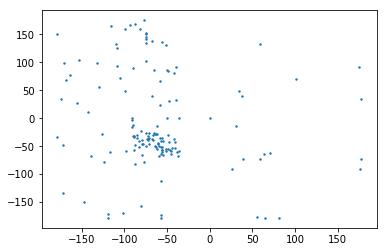

In [201]:
plt.scatter(beta[3], alpha[3], s=2)